In [13]:
#Necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from math import sqrt
import datetime 
import calendar
import sys
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.api import VAR

In [3]:
# Load the data from the Excel file
file_path = r'C:\Users\PHIRI003\OneDrive - Wageningen University & Research\Documents\WEcR Internship\Work\Eggs\Eggs.xlsx'
df = pd.read_excel(file_path, header=0)

# Ensure the data has a datetime index
df.index = df['Date']

#print(df.head())


In [4]:
# Define the function to create seasonal dummy variables

def SeasonalDummies(df, frequency='M'):
    nT = len(df)  # Number of observations
    startdate = df.index[0]  # Start date of the time series
    datetime = pd.DataFrame(data=pd.date_range(startdate, periods=nT, freq=frequency), columns=["datetime"])
    monthnumber = datetime["datetime"].dt.month  # Extract month numbers
    monthname = pd.DataFrame()  # DataFrame to store month names
    
    for i in range(nT):
        monthname.at[i, 'D'] = calendar.month_name[monthnumber[i]]  # Assign month names based on month numbers
    
    seasdum = pd.get_dummies(monthname)  # Create dummy variables for each month
    seasdum = seasdum.drop('D_January', axis=1)  # Drop January to avoid multicollinearity
    seasdum = seasdum.set_index(df.index)  # Set the index to match the original DataFrame
    seasdum = seasdum.astype(int)
    return seasdum

# Create seasonal dummies
seasdum = SeasonalDummies(df)

# Combine the data with the seasonal dummy variables
df = pd.concat([df, seasdum], axis=1)


In [5]:
#Create a break dummy
break_date = '2021-09-01'
df['break_dummy'] = (df['Date']>= break_date).astype(int)

#trend variable
df['trend'] = range(1, len(df) + 1)  

#differenced variables
columns = ['API',  'CPI', 'Oil', 'CornPI', 'break_dummy']

for column in columns:
    df[f'd_{column}'] = df[column].diff()

In [8]:
#lag length selection
from statsmodels.tsa.api import VAR
selected_data = df[['API', 'CPI']]

#model fitting 
model = VAR(selected_data)

#optimal lag length 
lag_order = model.select_order(maxlags=12)  

print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        12.80       12.84   3.626e+05       12.82
1        5.123       5.241       167.9       5.171
2        4.947      5.143*       140.7       5.026
3        4.908       5.183       135.4      5.020*
4        4.890       5.243       133.0       5.033
5       4.887*       5.319      132.6*       5.063
6        4.925       5.435       137.8       5.132
7        4.923       5.512       137.5       5.162
8        4.959       5.627       142.7       5.230
9        4.982       5.728       146.2       5.285
10       5.025       5.849       152.7       5.360
11       5.020       5.924       152.1       5.387
12       4.981       5.963       146.4       5.380
--------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [6]:
#VECM model estimation
import re

df.dropna(inplace=True)

Y1 = df[['API', 'CPI']]
X1 = df[[ 'd_Oil','d_CornPI','break_dummy',
         'D_April', 'D_August', 'D_December', 'D_February', 'D_July', 'D_June',
         'D_March', 'D_May', 'D_September', 'D_October', 'D_November']]

exog_names = ['d_Oil', 'd_CornPI', 'break_dummy', 
            'D_April', 'D_August', 'D_December', 
              'D_February', 'D_July', 'D_June', 'D_March', 'D_May', 'D_September', 
              'D_October', 'D_November']

#create a function for exogenous variable names
def rename_exog_variables(summary_text, exog_names):
    #mapping from 'exogX' to actual variable names
    exog_map = {f'exog{i+1}': name for i, name in enumerate(exog_names)}

    # Replacing the exogX in the summary text with the actual names
    for exog, name in exog_map.items():
        summary_text = re.sub(r'\b{}\b'.format(exog), name, summary_text)
    
    return summary_text

# Fit the VECM model
vecm = VECM(endog=Y1, exog=X1, k_ar_diff=5, coint_rank=1, deterministic='ct')  
vecm_fit= vecm.fit()

# Get the summary as a string
summary_str = vecm_fit.summary().as_text()

# Renaming exog variables
renamed_summary = rename_exog_variables(summary_str, exog_names)

# Print the modified summary
print(renamed_summary)


Det. terms outside the coint. relation & lagged endog. parameters for equation API
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d_Oil          0.0290      0.050      0.585      0.559      -0.068       0.126
d_CornPI          0.0980      0.092      1.067      0.286      -0.082       0.278
break_dummy          6.1584      2.422      2.543      0.011       1.412      10.905
D_April         -3.4895      3.413     -1.022      0.307     -10.179       3.200
D_August         10.8355      3.522      3.077      0.002       3.932      17.739
D_December         11.1989      3.125      3.584      0.000       5.074      17.324
D_February         18.1947      3.256      5.589      0.000      11.814      24.576
D_July          5.5729      3.437      1.622      0.105      -1.163      12.309
D_June          9.1203      3.510      2.598      0.009       2.241      16.000
D_March        16.6433

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Length of Y1: 161
Length of fittedvalues: 161


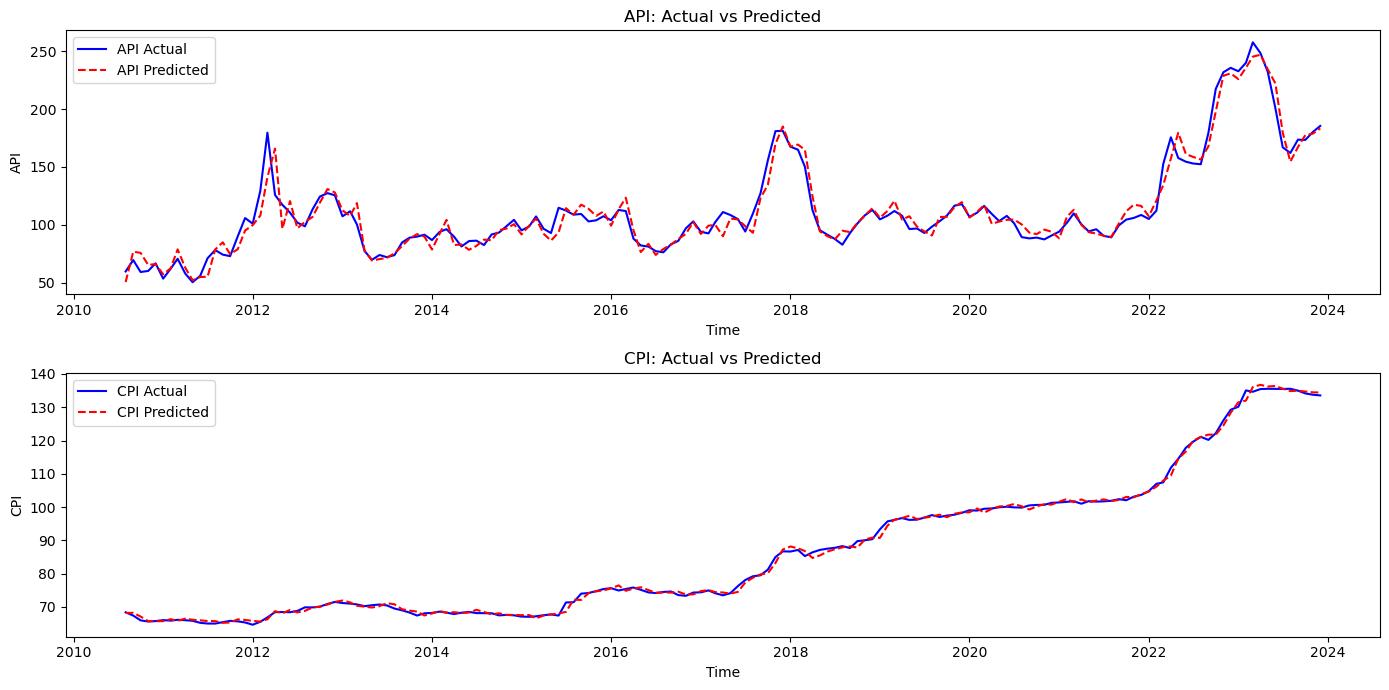

In [7]:
# Getting and plotting the predicted values
# removing the first 6 observations lost in lags and differencing
adjusted_Y1 = Y1.iloc[6:] 

# Checking the lengths of Y2 and fitted values for consistency
print(f"Length of Y1: {len(adjusted_Y1)}")
print(f"Length of fittedvalues: {len(vecm_fit.fittedvalues)}")

#predicted_df = vecm_fit1.fittedvalues
predicted_df = pd.DataFrame(vecm_fit.fittedvalues, columns=adjusted_Y1 .columns)
predicted_df.index = adjusted_Y1.index # Align the index with the actual data for comparison

# Combining actual and predicted values and renaming the columns
comparison_df = pd.concat([adjusted_Y1, predicted_df], axis=1)
comparison_df.columns = ['API_Actual', 'CPI_Actual', 'API_Predicted',  'CPI_Predicted']

import matplotlib.pyplot as plt

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot for API
plt.subplot(2, 1, 1)
plt.plot(comparison_df.index, comparison_df['API_Actual'], label='API Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['API_Predicted'], label='API Predicted', color='red', linestyle='--')
plt.title('API: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('API')
plt.legend()

# Plot for CPI
plt.subplot(2, 1, 2)
plt.plot(comparison_df.index, comparison_df['CPI_Actual'], label='CPI Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['CPI_Predicted'], label='CPI Predicted', color='red', linestyle='--')
plt.title('CPI: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()

plt.tight_layout()
plt.show()



In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#  apply the Ljung-Box test
for i in range(vecm_fit.resid.shape[1]):
    print(f"Ljung-Box Test for Residuals of Equation {i+1}:")
    ljung_box_results = acorr_ljungbox(vecm_fit.resid[:, i], lags=[1, 5, 8])
    print(ljung_box_results)
    print("\n")


Ljung-Box Test for Residuals of Equation 1:
    lb_stat  lb_pvalue
1  0.016814   0.896827
5  0.652423   0.985477
8  4.069800   0.850772


Ljung-Box Test for Residuals of Equation 2:
     lb_stat  lb_pvalue
1   0.073389   0.786465
5   2.150914   0.827894
8  11.126598   0.194629




In [14]:
df.dropna(inplace = True)

#Define endog and exog variables
X2 = df[[ 'd_Oil','d_CornPI', 'd_break_dummy', 'D_April', 'D_August', 'D_December', 'D_February',  'D_July',  'D_June',  'D_March', 'D_May', 'D_September', 'D_October', 'D_November']] 
#X = sm.add_constant(X)
Y2 = df[['d_API','d_CPI']] 

# Fit the VAR model
var = VAR(Y2, X2)  
var_fit = var.fit(5)

# Print the modified summary
print(var_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, Aug, 2024
Time:                     09:52:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.72789
Nobs:                     162.000    HQIC:                   5.16185
Log likelihood:          -796.505    FPE:                    119.092
AIC:                      4.77493    Det(Omega_mle):         89.3781
--------------------------------------------------------------------
Results for equation d_API
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -8.767621         3.078697           -2.848           0.004
d_Oil                 0.042103         0.056899            0.740           0.459
d_CornPI              0.160184         0.107603            1

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [9]:
from statsmodels.stats.diagnostic import het_arch
import pandas as pd

# Conduct the ARCH test for heteroscedasticity for each equation
arch_test_results = [het_arch(resid) for resid in vecm_fit.resid.T]

# Create a DataFrame to store the results
columns = ['Test Statistic', 'P-value', 'Lags used']
results_df = pd.DataFrame(columns=columns)

# Fill the DataFrame with the results
for i, result in enumerate(arch_test_results):
    test_statistic, p_value, lags_used, _ = result
    results_df.loc[f'Equation {i+1}'] = [test_statistic, p_value, lags_used]

# Display the results
print(results_df)



            Test Statistic       P-value  Lags used
Equation 1       52.348123  9.836712e-08   7.428888
Equation 2        8.123511  6.167738e-01   0.795996


<Figure size 1000x500 with 0 Axes>

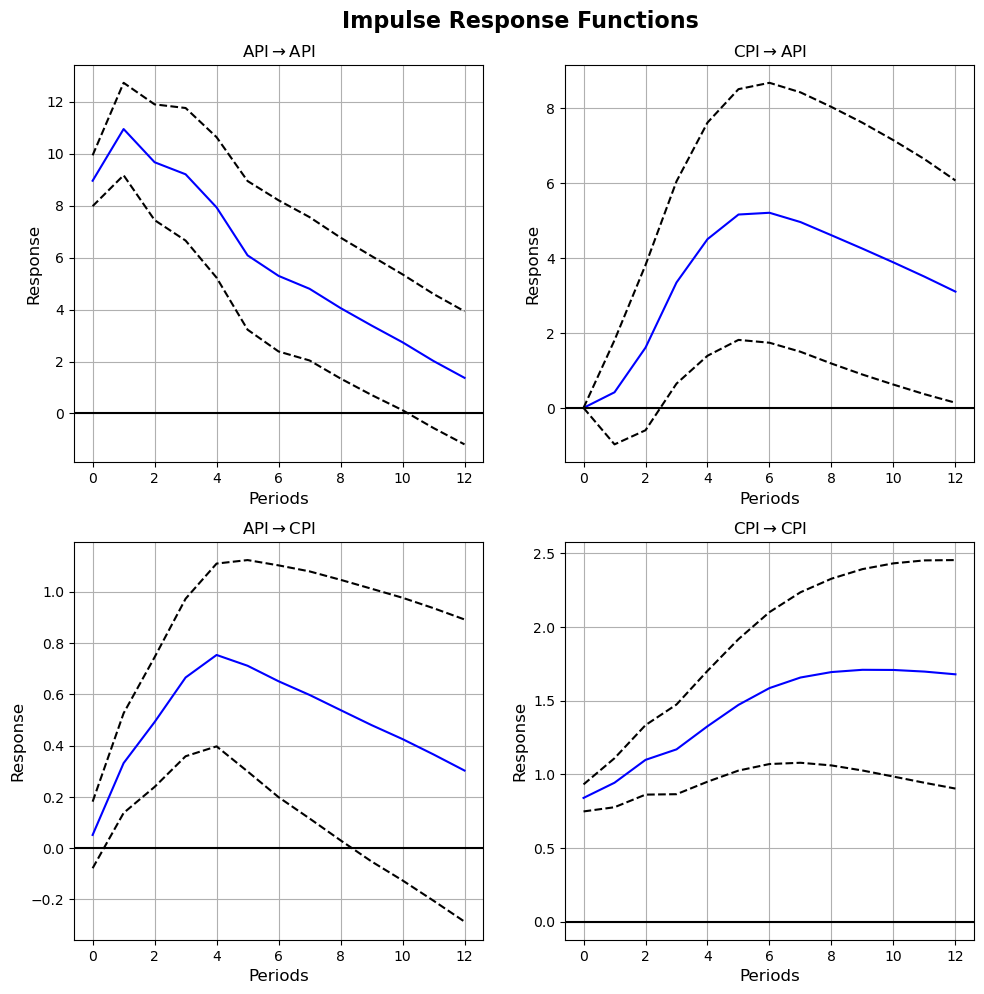

In [17]:
import matplotlib.pyplot as plt

# Generate impulse response functions
irf = vecm_fit.irf(periods=12)

# Plot the IRFs without confidence intervals
fig = plt.figure(figsize=(10, 5))  # Adjust the figure size (longer and narrower)
irf.plot(orth=True, plot_stderr=)  # Disable the confidence intervals

# Customize the plot (title and labels)
plt.suptitle('Impulse Response Functions ', fontsize=16, fontweight='bold')

# Customize each subplot in the figure
for ax in plt.gcf().axes:
    ax.set_xlabel('Periods', fontsize=12)
    ax.set_ylabel('Response', fontsize=12)
    ax.grid(True)  # Add gridlines for better readability
    ax.xaxis.set_tick_params(labelbottom=True)  # Ensure x-axis labels are visible on all plots

# Save and show the plot
plt.savefig('irf_plot_no_ci_period_labels.png', bbox_inches='tight')  # Save the figure with tight layout
plt.show()


In [16]:
#Factor Error Variance decomposition
from statsmodels.tsa.api import VAR

var_model = VAR(vecm_fit.model.endog)
#var_fit = var_model.fit(maxlags=vecm_fit.k_ar_diff)

n_lags = vecm_fit.k_ar

var_fit = var_model.fit(maxlags=n_lags)

# Step 3: Perform variance decomposition
fevd = var_fit.fevd(periods=12)

# Step 4: Print the results
print(fevd.summary())


FEVD for y1
            y1        y2
0     1.000000  0.000000
1     0.995658  0.004342
2     0.982988  0.017012
3     0.944374  0.055626
4     0.882950  0.117050
5     0.831581  0.168419
6     0.794433  0.205567
7     0.768178  0.231822
8     0.749669  0.250331
9     0.735623  0.264377
10    0.723182  0.276818
11    0.711755  0.288245

FEVD for y2
            y1        y2
0     0.007648  0.992352
1     0.054911  0.945089
2     0.113715  0.886285
3     0.164016  0.835984
4     0.194125  0.805875
5     0.204092  0.795908
6     0.200745  0.799255
7     0.192177  0.807823
8     0.183073  0.816927
9     0.174516  0.825484
10    0.166880  0.833120
11    0.159994  0.840006


None


In [7]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_test(df_with_dummies, var1, var2, max_lag):
    print(f'Granger Causality Test: {var1} causes {var2}')
    test_result = grangercausalitytests(df[[var2, var1]], max_lag, verbose=True)
    return test_result

# Usage
max_lag = 5

granger_causality_test(df, 'API', 'CPI', max_lag)
granger_causality_test(df, 'CornPI', 'CPI', max_lag)
granger_causality_test(df, 'Oil', 'CPI', max_lag)
granger_causality_test(df, 'CPI', 'API', max_lag)
granger_causality_test(df, 'CornPI', 'API', max_lag)
granger_causality_test(df, 'Oil', 'API', max_lag)


Granger Causality Test: API causes CPI

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.1727 , p=0.0000  , df_denom=163, df_num=1
ssr based chi2 test:   chi2=19.5256 , p=0.0000  , df=1
likelihood ratio test: chi2=18.4601 , p=0.0000  , df=1
parameter F test:         F=19.1727 , p=0.0000  , df_denom=163, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.3077 , p=0.0000  , df_denom=160, df_num=2
ssr based chi2 test:   chi2=23.3222 , p=0.0000  , df=2
likelihood ratio test: chi2=21.8144 , p=0.0000  , df=2
parameter F test:         F=11.3077 , p=0.0000  , df_denom=160, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.0991  , p=0.0000  , df_denom=157, df_num=3
ssr based chi2 test:   chi2=25.3805 , p=0.0000  , df=3
likelihood ratio test: chi2=23.5983 , p=0.0000  , df=3
parameter F test:         F=8.0991  , p=0.0000  , df_denom=157, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions shou

{1: ({'ssr_ftest': (0.7188152274913178, 0.39777604397103683, 163.0, 1),
   'ssr_chi2test': (0.7320449556046549, 0.392221140843209, 1),
   'lrtest': (0.7304355594424123, 0.39274204315618655, 1),
   'params_ftest': (0.7188152274912045, 0.3977760439710786, 163.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.4938380647037063, 0.6112066974852542, 160.0, 2),
   'ssr_chi2test': (1.0185410084513942, 0.6009337976194474, 2),
   'lrtest': (1.015410171728945, 0.6018752471090254, 2),
   'params_ftest': (0.49383806470364333, 0.6112066974852979, 160.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.1099351648222395, 0.34688710635481573, 157.0, 3),
   'ssr_chi2test': (3.478268159825107, 0.32359162469458735, 3),
   'lrtest': (3.4418963218579393, 0.328376528791034, 3),
   'params_ftest': (1.1099351648222398, 0.34688710635481573, 157.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.